In [ ]:
# Load libraries


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Vietnam Stock Prediction

In [ ]:
window_size=120 # Time window for data feature (size of 'number of days').
prediction_window=7 #This is how many days in the future the model will predict
def get_x_and_y_data(file_location):
  #Read the data
  df = pd.read_csv(file_location)
  X_data = []
  y_data = []


  # Only get the close price (index 4 in the data frame)
  for i in range(1, len(df) - window_size - prediction_window - 1):
      first = df.iloc[i, 2]
      data_feature = []
      data_label = []
      
      # Get a window_size time frame for data feature
      for j in range(window_size):
          data_feature.append(df.iloc[i + j, 4])
          
      # Next 7 values is the label (price in the next 7 days) to be predicted
      for j in range(prediction_window):
          data_label.append(df.iloc[i + window_size + j, 4])
      
      # Append new data sample (feature and label) to X_data and y_data
      X_data.append(np.array(data_feature).reshape(window_size, 1))
      y_data.append(np.array(data_label))


  # Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

  # Convert from lists to Numpy arrays for reshaping purpose
  X_train = np.array(X_train)
  X_val = np.array(X_val)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)

  # Reshape the numpy array to fit the neural network input shape requirement
  X_train = X_train.reshape(X_train.shape[0], window_size, 1)
  X_val = X_val.reshape(X_val.shape[0], window_size, 1)
  X_test = X_test.reshape(X_test.shape[0], window_size, 1)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
#Company criteria: From Construction sector, on HOSE, stock rating over 3.5, have at least 5 years of divident.
#I chose these stocks because the construction sector in Vietnam is known to be very stable.
#Stocks on HOSE is more stable than other trading platforms since companies on it are often larger
#Stock rating over 3.5 and at least 5 years of dividend ensures that the chosen companies are extremely stable. This makes it easier to predict

#get the list of company stock
file_path=["/content/BMP-VNINDEX-History.csv", "/content/DHA-VNINDEX-History.csv", "/content/DPG-VNINDEX-History.csv", "/content/FCM-VNINDEX-History.csv", "/content/HU3-VNINDEX-History.csv", "/content/HUB-VNINDEX-History.csv", "/content/KPF-VNINDEX-History.csv", "/content/LBM-VNINDEX-History.csv", "/content/MDG-VNINDEX-History.csv", "/content/NAV-VNINDEX-History.csv", "/content/TCD-VNINDEX-History.csv", "/content/THG-VNINDEX-History.csv", "/content/UIC-VNINDEX-History.csv","/content/VSI-VNINDEX-History.csv"]

#Create arrays to store our data
X_train = np.empty((0, window_size, 1))
X_val = np.empty((0, window_size, 1))
X_test = np.empty((0, window_size, 1))
y_train = np.empty((0,prediction_window))
y_val = np.empty((0, prediction_window))
y_test=np.empty((0, prediction_window))

#This loop gets the training, testing, and validation testing data from each stock and then stacks it onto the appropriate variable
for i in file_path:
  X_train = np.vstack((X_train, get_x_and_y_data(i)[0]))
  X_val = np.vstack((X_val, get_x_and_y_data(i)[1]))
  X_test = np.vstack((X_test, get_x_and_y_data(i)[2]))
  y_train = np.vstack((y_train, get_x_and_y_data(i)[3]))
  y_val = np.vstack((y_val, get_x_and_y_data(i)[4]))
  y_test = np.vstack((y_test, get_x_and_y_data(i)[5]))
  print(i)

/content/BMP-VNINDEX-History.csv
/content/DHA-VNINDEX-History.csv
/content/DPG-VNINDEX-History.csv
/content/FCM-VNINDEX-History.csv
/content/HU3-VNINDEX-History.csv
/content/HUB-VNINDEX-History.csv
/content/KPF-VNINDEX-History.csv
/content/LBM-VNINDEX-History.csv
/content/MDG-VNINDEX-History.csv
/content/NAV-VNINDEX-History.csv
/content/TCD-VNINDEX-History.csv
/content/THG-VNINDEX-History.csv
/content/UIC-VNINDEX-History.csv
/content/VSI-VNINDEX-History.csv


In [ ]:
print("Shape of X training set: ", X_train.shape)
print("Shape of X validation set: ", X_val.shape)
print("Shape of X test set: ", X_test.shape)
print("Shape of y training set: ", y_train.shape)
print("Shape of y validation set: ", y_val.shape)
print("Shape of y test set: ", y_test.shape)

Shape of X training set:  (24973, 120, 1)
Shape of X validation set:  (6251, 120, 1)
Shape of X test set:  (7813, 120, 1)
Shape of y training set:  (24973, 7)
Shape of y validation set:  (6251, 7)
Shape of y test set:  (7813, 7)


In [ ]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature = np.min(X_val[i])
    max_feature = np.max(X_val[i])
    X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
#Build the model
#From several trials, I found out that this is the best configurations for the model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=128))
model.add(Dropout(0.2))

model.add(Dense(units=prediction_window))

In [ ]:
#compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(), loss='mse', metrics=['mse'])

In [ ]:
#This is the time series split function from scikitlearn, I will use this to split data for cross validation
cross_validation_split = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in cross_validation_split.split(X_train_norm):
    # Split the data into training and testing sets
    X_train_fold, X_test_fold = X_train_norm[train_index], X_train_norm[test_index]
    y_train_fold, y_test_fold = y_train_norm[train_index], y_train_norm[test_index]    

    #Fit model onto the data
    model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=512)

    # Make predictions on the testing set
    y_pred_fold = model.predict(X_test_fold)

    # Calculate the MSE and store it into the list
    mse = mean_squared_error(y_test_fold, y_pred_fold)
    mse_scores.append(mse)

Epoch 1/20
9/9 [==============================] - 9s 84ms/step - loss: 0.2340 - mse: 0.2340
Epoch 2/20
9/9 [==============================] - 1s 75ms/step - loss: 0.1008 - mse: 0.1008
Epoch 3/20
9/9 [==============================] - 1s 74ms/step - loss: 0.0764 - mse: 0.0764
Epoch 4/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0608 - mse: 0.0608
Epoch 5/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0534 - mse: 0.0534
Epoch 6/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0487 - mse: 0.0487
Epoch 7/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0456 - mse: 0.0456
Epoch 8/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0441 - mse: 0.0441
Epoch 9/20
9/9 [==============================] - 1s 74ms/step - loss: 0.0425 - mse: 0.0425
Epoch 10/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0414 - mse: 0.0414
Epoch 11/20
9/9 [==============================] - 1s 75ms/step - loss: 0.0393 

In [ ]:
#The MSE of the 5 folds have roughly the same value which means this model is generalized and doesn't suffer from overfitting
#The MSE of the first fold is the largest as the first fold has the least training data
avg_mse = np.mean(mse_scores)
print("Average MSE:" + str(avg_mse))
print("Mse in 5 folds: " + str(mse_scores))

Average MSE:0.027154211903047332
Mse in 5 folds: [0.03286205679585736, 0.027996533059767088, 0.024098071380353685, 0.02680965954886364, 0.024004738730394888]


In [ ]:
#Train the model
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=512)

Epoch 1/20
49/49 [==============================] - 18s 114ms/step - loss: 0.0908 - mse: 0.0908 - val_loss: 0.0510 - val_mse: 0.0510
Epoch 2/20
49/49 [==============================] - 5s 93ms/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0413 - val_mse: 0.0413
Epoch 3/20
49/49 [==============================] - 4s 88ms/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 4/20
49/49 [==============================] - 4s 88ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 5/20
49/49 [==============================] - 4s 88ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 6/20
49/49 [==============================] - 4s 89ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 7/20
49/49 [==============================] - 5s 94ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 8/20
49/49 [==============================] - 5s 94ms/step - loss: 0.0290 -

In [ ]:
# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

245/245 [==============================] - 3s 8ms/step
MSE on the test set:  0.030764362269537587


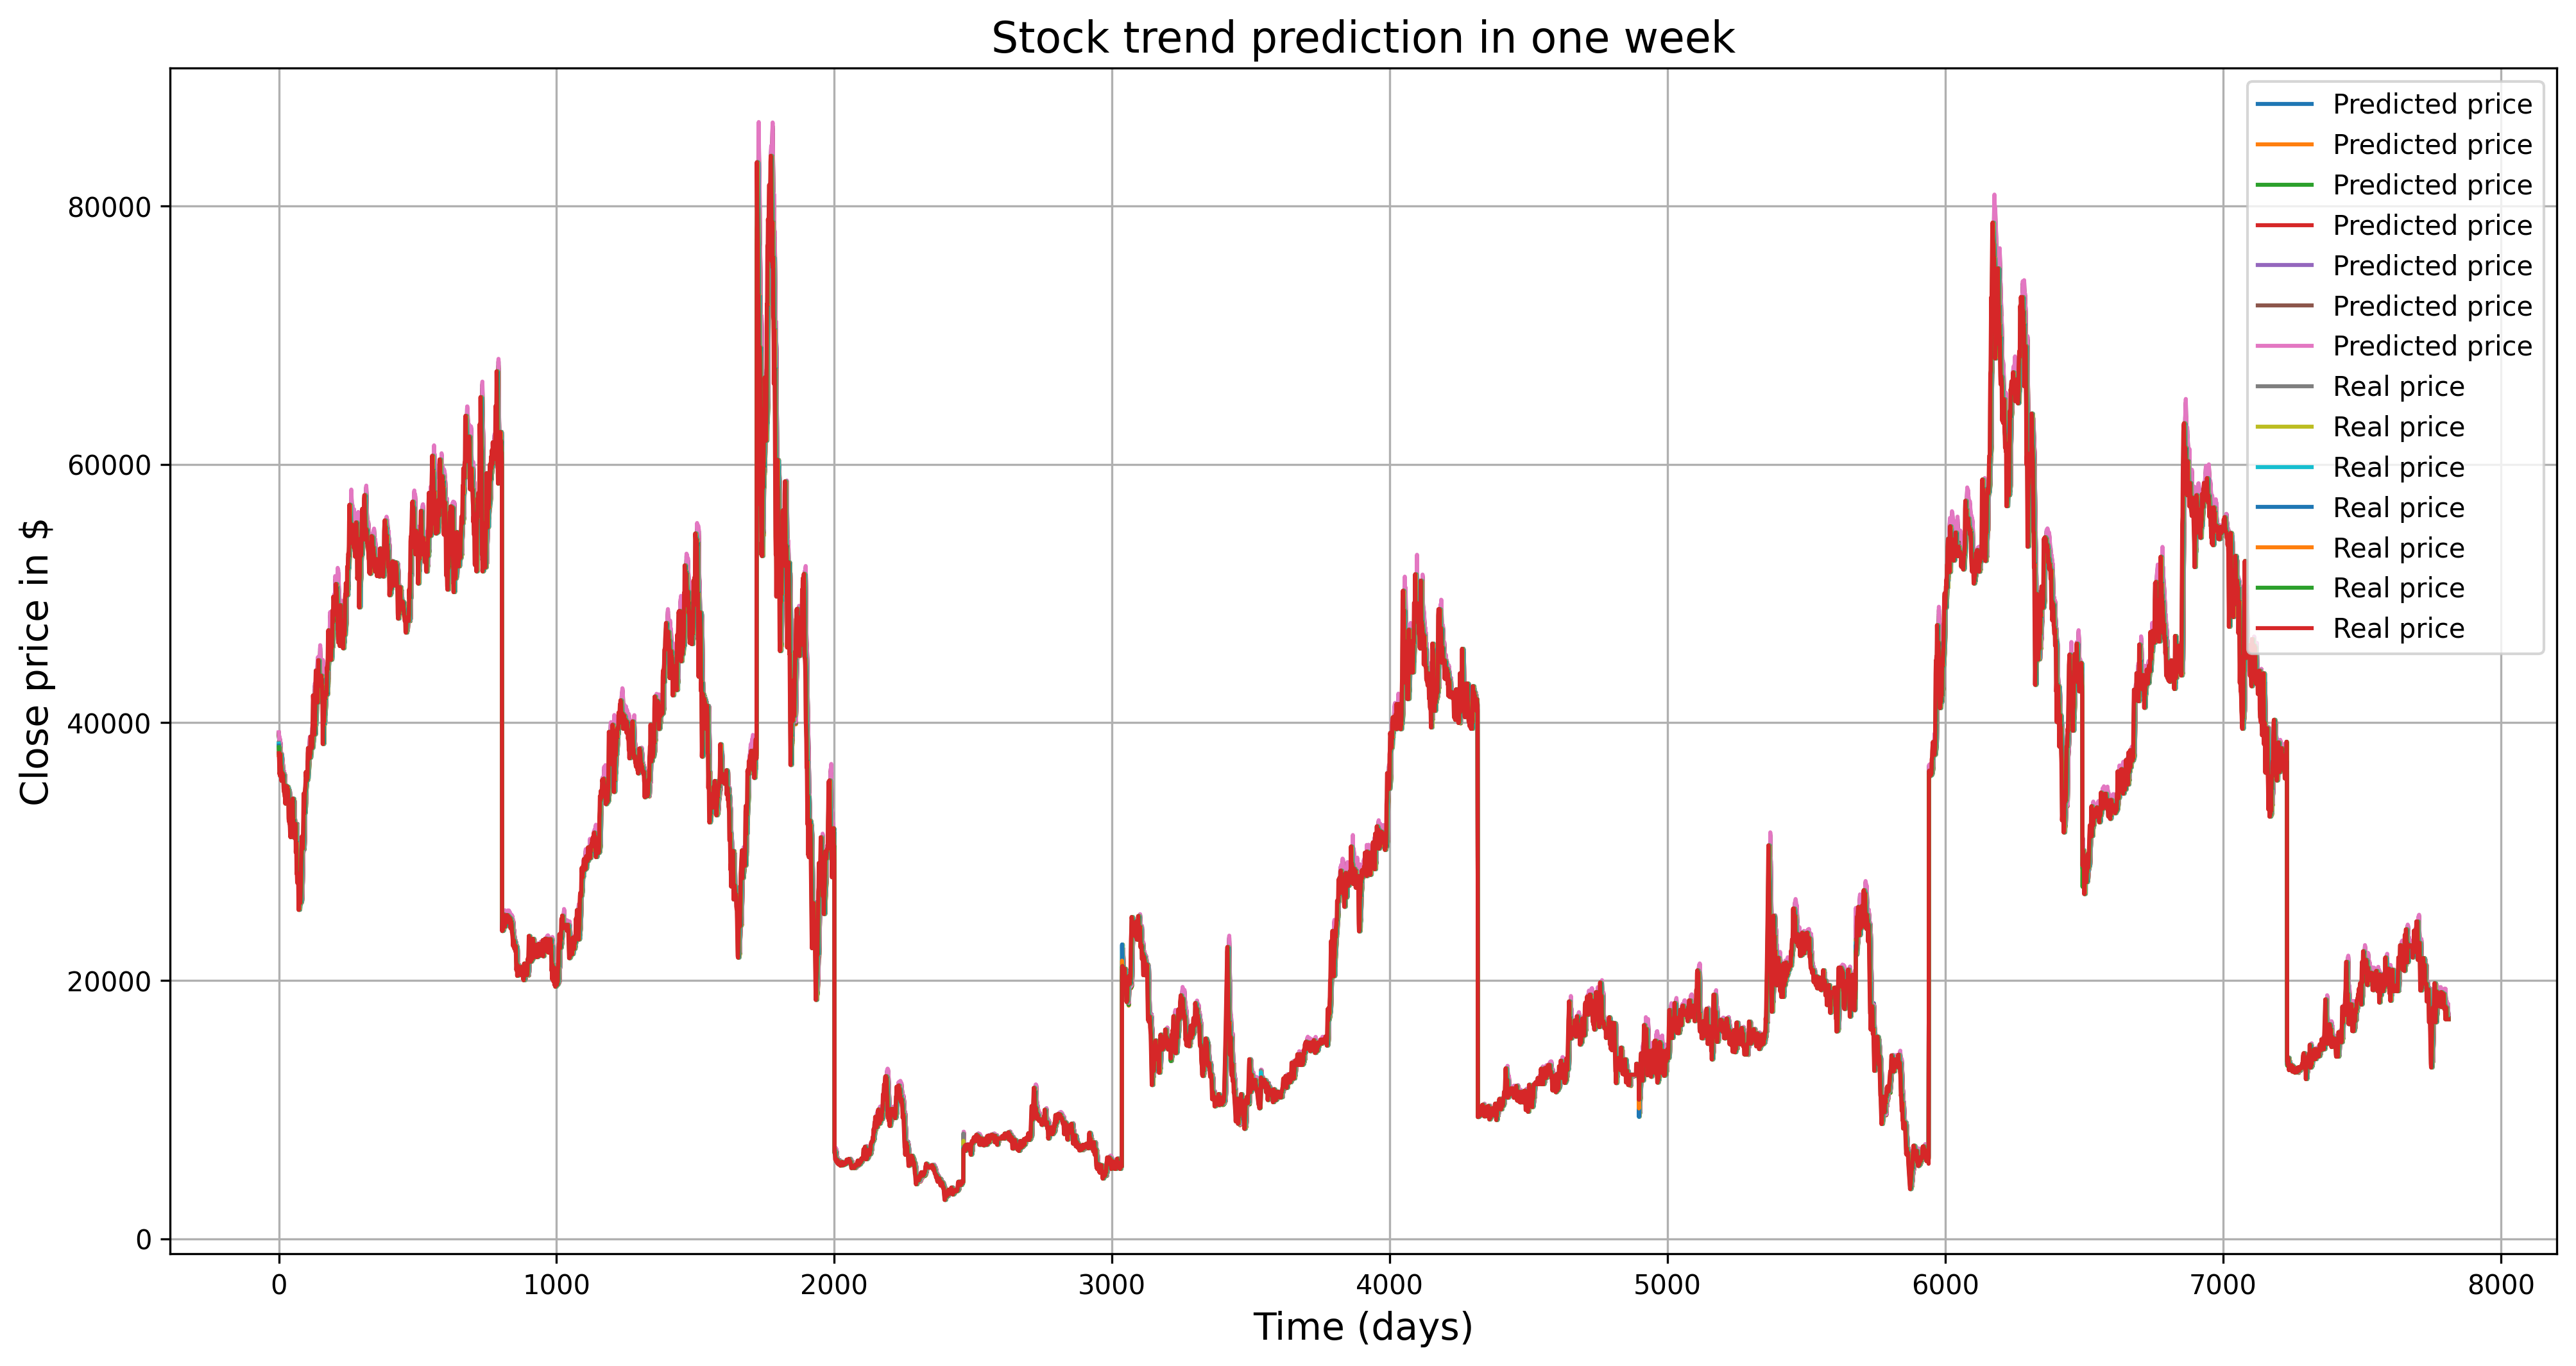

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature
# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one week', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Close price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

#Please ignore the multiple predicted price and real price legends. They are the result of stacking data from multiple companies together

Load model so I won't have to retrain the model everytime I want to adjust my code

In [ ]:
#save the model so I won't have to rerun model to tune the other sections
from tensorflow.keras.models import save_model
save_model(model, "model.h5")


In [ ]:
#import pre-saved model so I won't have to rerun model to tune the other sections
from tensorflow.keras.models import load_model
 
model = load_model('/content/model.h5')

# NASDAQ Stock Prediction 

In [ ]:
def get_x_and_y_data_nas(file_location):
  
  #Load the data
  df = pd.read_csv(file_location)
  X_data = []
  y_data = []


  # Only get the adjusted open price (index 6 in the data frame)
  for i in range(1, len(df) - window_size - prediction_window - 1):
      first = df.iloc[i, 2]
      data_feature = []
      data_label = []
      
      # Get a window_size time frame for data feature
      for j in range(window_size):
          data_feature.append(df.iloc[i + j, 6])
          
      # Next 7 values is the label (prices in the next week) to be predicted
      for j in range(prediction_window):
          data_label.append(df.iloc[i + window_size + j, 6])
      
      # Append new data sample (feature and label) to X_data and y_data
      X_data.append(np.array(data_feature).reshape(window_size, 1))
      y_data.append(np.array(data_label))


  # Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

  # Convert from lists to Numpy arrays for reshaping purpose
  X_train = np.array(X_train)
  X_val = np.array(X_val)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)

  # Reshape the numpy array to fit the neural network input shape requirement
  X_train = X_train.reshape(X_train.shape[0], window_size, 1)
  X_val = X_val.reshape(X_val.shape[0], window_size, 1)
  X_test = X_test.reshape(X_test.shape[0], window_size, 1)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
#Company criteria: NASDAQ companies with market cap of over 150 Billion USD
#I chose this because companies with extremely large market cap are usually very stable

#get the file path
file_path_nas=["/content/AAPL.csv", "/content/ADBE.csv", "/content/AMD.csv", "/content/AMZN.csv", "/content/CMCSA.csv", "/content/COST.csv", "/content/CSCO.csv", "/content/MSFT.csv", "/content/NFLX.csv", "/content/NVDA.csv"]

#create arrays to store data into
X_train_nas = np.empty((0, window_size, 1))
X_val_nas = np.empty((0, window_size, 1))
X_test_nas = np.empty((0, window_size, 1))
y_train_nas = np.empty((0,prediction_window))
y_val_nas = np.empty((0, prediction_window))
y_test_nas = np.empty((0, prediction_window))

#get the train, test, and validation data for each stock and stack it into the appropriate array
for i in file_path_nas:
  X_train_nas = np.vstack((X_train_nas, get_x_and_y_data_nas(i)[0]))
  X_val_nas = np.vstack((X_val_nas, get_x_and_y_data_nas(i)[1]))
  X_test_nas = np.vstack((X_test_nas, get_x_and_y_data_nas(i)[2]))
  y_train_nas = np.vstack((y_train_nas, get_x_and_y_data_nas(i)[3]))
  y_val_nas = np.vstack((y_val_nas, get_x_and_y_data_nas(i)[4]))
  y_test_nas = np.vstack((y_test_nas, get_x_and_y_data_nas(i)[5]))
  print(i)

/content/AAPL.csv
/content/ADBE.csv
/content/AMD.csv
/content/AMZN.csv
/content/CMCSA.csv
/content/COST.csv
/content/CSCO.csv
/content/MSFT.csv
/content/NFLX.csv
/content/NVDA.csv


In [ ]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm_nas = X_train_nas.copy()
y_train_norm_nas = y_train_nas.copy()
for i in range(0, len(X_train_nas)):
    min_feature_nas = np.min(X_train_nas[i])
    max_feature_nas = np.max(X_train_nas[i])
    X_train_norm_nas[i] = (X_train_nas[i] - min_feature_nas) / (max_feature_nas - min_feature_nas)
    y_train_norm_nas[i] = (y_train_nas[i] - min_feature_nas) / (max_feature_nas - min_feature_nas)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm_nas = X_val_nas.copy()
y_val_norm_nas = y_val_nas.copy()
for i in range(0, len(X_val_nas)):
    min_feature_nas = np.min(X_val_nas[i])
    max_feature_nas = np.max(X_val_nas[i])
    X_val_norm_nas[i] = (X_val_nas[i] - min_feature_nas) / (max_feature_nas - min_feature_nas)
    y_val_norm_nas[i] = (y_val_nas[i] - min_feature_nas) / (max_feature_nas - min_feature_nas)

# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm_nas = X_test_nas.copy()
y_test_norm_nas = y_test_nas.copy()
for i in range(0, len(X_test_nas)):
    min_feature_nas = np.min(X_test_nas[i])
    max_feature_nas = np.max(X_test_nas[i])
    X_test_norm_nas[i] = (X_test_nas[i] - min_feature_nas) / (max_feature_nas - min_feature_nas)
    y_test_norm_nas[i] = (y_test_nas[i] - min_feature_nas) / (max_feature_nas - min_feature_nas)

In [ ]:
#Build the model
model_nas = Sequential()
model_nas.add(LSTM(units=128, return_sequences=True, input_shape=(window_size, 1)))
model_nas.add(Dropout(0.2))

model_nas.add(LSTM(units=128, return_sequences=True))
model_nas.add(Dropout(0.2))

model_nas.add(LSTM(units=128, return_sequences=True))
model_nas.add(Dropout(0.2))

model_nas.add(LSTM(units=128))
model_nas.add(Dropout(0.2))

model_nas.add(Dense(units=prediction_window))

In [ ]:
#Compile the model
model_nas.compile(optimizer= tf.keras.optimizers.Adam(), loss='mse', metrics=['mse'])

In [ ]:
#This is a function from the scikitlearn library that helps with splitting time series data for cross-validatoin
cross_validation_split = TimeSeriesSplit(n_splits=5)
mse_scores_nas = []

#Run cross validation
for train_index, test_index in cross_validation_split.split(X_train_norm_nas):
    # Split the data into training and testing sets
    X_train_fold, X_test_fold = X_train_norm_nas[train_index], X_train_norm_nas[test_index]
    y_train_fold, y_test_fold = y_train_norm_nas[train_index], y_train_norm_nas[test_index]    

    model_nas.fit(X_train_fold, y_train_fold, epochs=20, batch_size=512)

    # Make predictions on the testing set
    y_pred_fold = model_nas.predict(X_test_fold)

    # Calculate MSE and store it
    mse = mean_squared_error(y_test_fold, y_pred_fold)
    mse_scores_nas.append(mse)

Epoch 1/20
18/18 [==============================] - 14s 86ms/step - loss: 0.1613 - mse: 0.1613
Epoch 2/20
18/18 [==============================] - 1s 80ms/step - loss: 0.0704 - mse: 0.0704
Epoch 3/20
18/18 [==============================] - 1s 82ms/step - loss: 0.0543 - mse: 0.0543
Epoch 4/20
18/18 [==============================] - 1s 80ms/step - loss: 0.0502 - mse: 0.0502
Epoch 5/20
18/18 [==============================] - 1s 80ms/step - loss: 0.0461 - mse: 0.0461
Epoch 6/20
18/18 [==============================] - 1s 80ms/step - loss: 0.0433 - mse: 0.0433
Epoch 7/20
18/18 [==============================] - 1s 80ms/step - loss: 0.0415 - mse: 0.0415
Epoch 8/20
18/18 [==============================] - 1s 80ms/step - loss: 0.0390 - mse: 0.0390
Epoch 9/20
18/18 [==============================] - 1s 80ms/step - loss: 0.0376 - mse: 0.0376
Epoch 10/20
18/18 [==============================] - 1s 80ms/step - loss: 0.0362 - mse: 0.0362
Epoch 11/20
18/18 [==============================] - 1s 81

In [ ]:
#The MSE of the 5 folds have roughly the same value which means this model is generalized and doesn't suffer from overfitting
#The MSE of the first fold is the largest as the first fold has the least training data

avg_mse_nas = np.mean(mse_scores_nas)
print("Average MSE:" + str(avg_mse_nas))
print("Mse in 5 folds: " + str(mse_scores_nas))

Average MSE:0.02240857288660351
Mse in 5 folds: [0.023502230511241395, 0.022316781282798983, 0.02356884927369719, 0.02041896742055648, 0.022236035944723512]


In [ ]:
#Train the model
history_nas = model_nas.fit(X_train_norm_nas, y_train_norm_nas, validation_data=(X_val_norm_nas,y_val_norm_nas), epochs=20, batch_size=512)

Epoch 1/20
106/106 [==============================] - 18s 107ms/step - loss: 0.0782 - mse: 0.0782 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 2/20
106/106 [==============================] - 10s 97ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 3/20
106/106 [==============================] - 10s 99ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 4/20
106/106 [==============================] - 10s 94ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 5/20
106/106 [==============================] - 10s 97ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 6/20
106/106 [==============================] - 10s 93ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 7/20
106/106 [==============================] - 10s 93ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 8/20
106/106 [==============================] - 10s 97m

In [ ]:
# Get prediction on the test data
y_pred_norm_nas = model_nas.predict(X_test_norm_nas)
print("MSE on the test set: ", mean_squared_error(y_pred_norm_nas, y_test_norm_nas))

528/528 [==============================] - 5s 8ms/step
MSE on the test set:  0.02186047713412558


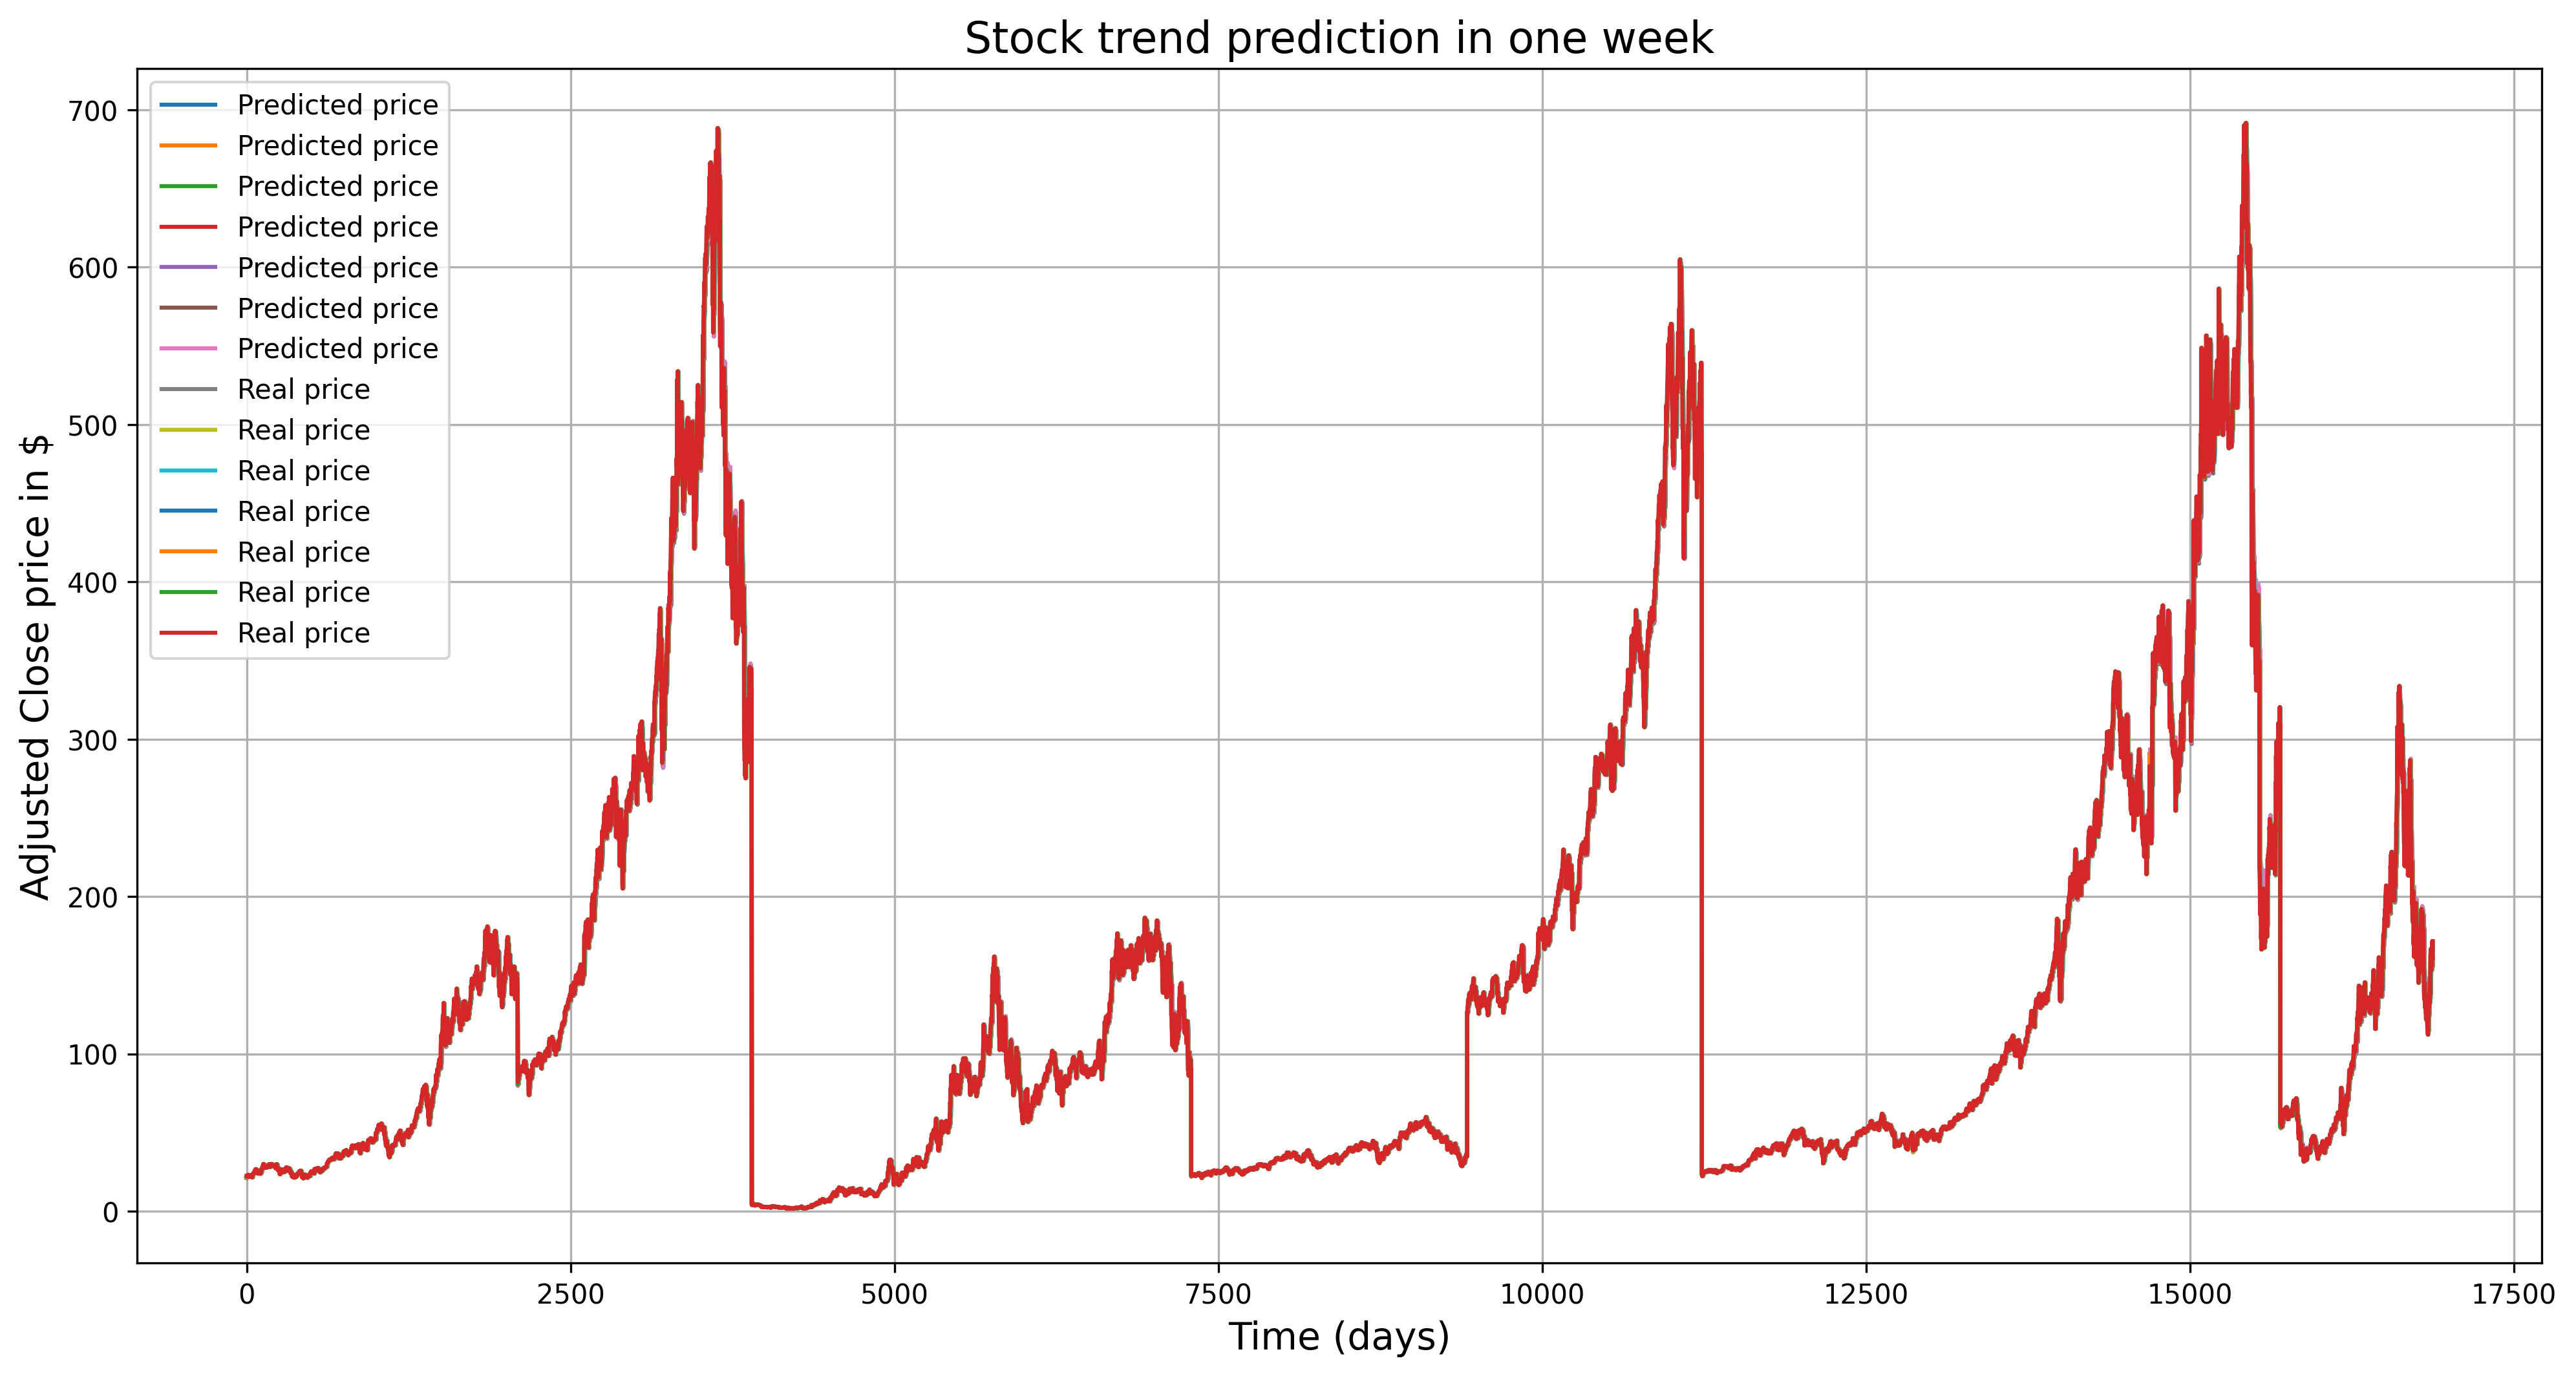

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm_nas = y_pred_norm_nas
for i in range(0, len(y_pred_denorm_nas)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature_nas = np.min(X_test_nas[i])
    max_feature_nas = np.max(X_test_nas[i])
    y_pred_denorm_nas[i] = y_pred_norm_nas[i] * (max_feature_nas - min_feature_nas) + min_feature_nas
# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm_nas, label='Predicted price')
plt.plot(y_test_nas, label='Real price')
plt.title('Stock trend prediction in one week', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Adjusted Close price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# Trading Point Prediction - Sell Point Prediction

In [ ]:
def predict_sell_point(filepath, buy_price):
  data = pd.read_csv(filepath)
  #Get the price from the last 120 days 
  predict_data = np.array(data[-120:]["Open"])
  predict_data = predict_data.reshape(1, 120, 1)
  
  #Normalize the data
  predict_data_norm = predict_data.copy()
  for i in range(0, len(predict_data)):
      min_feature = np.min(predict_data[i])
      max_feature = np.max(predict_data[i])
      predict_data_norm[i] = (predict_data[i] - min_feature) / (max_feature - min_feature)
  
  #Predict prices one week in the future
  predict = model.predict(predict_data_norm)
  
  #Denorm the value
  predict_denorm = predict
  for i in range(0, len(predict_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
      min_feature = np.min(predict_data[i])
      max_feature = np.max(predict_data[i])
      predict_denorm[i] = predict[i] * (max_feature - min_feature) + min_feature
  
  #Get the max value
  max_value = np.max(predict_denorm)
  
  #If the max stock price in the next week is greater than the current price, advise the user to sell it
  if max_value > buy_price:
    print("Stock Ticker: " + filepath[9:12])
    print("You should consider selling the stock in the next " + str(list(predict_denorm.reshape(7)).index(max_value) + 1) + " days. Stock price at that point will increase by "+ str((max_value / buy_price) * 100 - 100) +"%." + " The highest stock price in the next week is " + str(max_value))
  
  #If the max stock price in the next week is less than the current price, advise the user against selling it
  else:
    print("Stock Ticker: " + filepath[9:12])
    print("You should consider not selling your stock in the next week as you will be at a loss. The highest stock price in the next week is " + str(max_value))

In [ ]:
#Example of when a user should sell a stock
predict_sell_point("/content/DPG-VNINDEX-History.csv", 23400)

1/1 [==============================] - 0s 26ms/step
Stock Ticker: DPG
You should consider selling the stock in the next 3 days. Stock price at that point will increase by 22.6832264957265%. The highest stock price in the next week is 28707.875


In [ ]:
#Example of when a user should not sell a stock
predict_sell_point("/content/THG-VNINDEX-History.csv", 50000)

1/1 [==============================] - 0s 27ms/step
Stock Ticker: THG
You should consider not selling your stock in the next week as you will be at a loss. The highest stock price in the next week is 42402.63


# Trading Point Prediction - Buy Point Prediction

In [ ]:
def predict_buy_point(filepath):
  data = pd.read_csv(filepath)
  #get the price from the past 120 days
  predict_data = np.array(data[-120:]["Open"])
  predict_data = predict_data.reshape(1, 120, 1)
  
  #normalized the data
  predict_data_norm = predict_data.copy()
  for i in range(0, len(predict_data)):
      min_feature = np.min(predict_data[i])
      max_feature = np.max(predict_data[i])
      predict_data_norm[i] = (predict_data[i] - min_feature) / (max_feature - min_feature)
  
  #predict the price in the next week
  predict = model.predict(predict_data_norm)
  
  #denorm the predicted prices
  predict_denorm = predict
  for i in range(0, len(predict_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
      min_feature = np.min(predict_data[i])
      max_feature = np.max(predict_data[i])
      predict_denorm[i] = predict[i] * (max_feature - min_feature) + min_feature
  
  #get the current price and the minimum price in the next week
  min_value = np.min(predict_denorm)
  current_price = int(data["Close"][-1:].values)
  
  #If the minimum predicted price is less than the current price, advise the user to buy the stock
  if min_value < current_price:
    print("Stock Ticker: " + filepath[9:12])
    print("You should consider buying the stock in the next " + str(list(predict_denorm.reshape(7)).index(min_value) + 1) + " days. Stock price at that point will decrease by "+ str((current_price / min_value) * 100 - 100) +"% compared to right now." + " The lowest stock price in the next week is " + str(min_value) + " and right now the stock price is " + str(current_price))
  
  #If the minimum predicted price is more than the current price, advise the user against buying the stock
  else:
    print("Stock Ticker: " + filepath[9:12])
    print("You should consider not buying that stock in the next week, the price will increase compared to right now. The lowest stock price in the next week is " + str(min_value) + " and right now the stock price is " + str(current_price))

In [ ]:
#An example when the user should not buy the stock
predict_buy_point("/content/TCD-VNINDEX-History.csv")

1/1 [==============================] - 0s 26ms/step
Stock Ticker: TCD
You should consider not buying that stock in the next week, the price will increase compared to right now. The lowest stock price in the next week is 5922.5713 and right now the stock price is 5860


In [ ]:
#An example when the user should buy a stock
predict_buy_point("/content/NAV-VNINDEX-History.csv")

1/1 [==============================] - 0s 23ms/step
Stock Ticker: NAV
You should consider buying the stock in the next 1 days. Stock price at that point will decrease by 0.13092937768064417% compared to right now. The lowest stock price in the next week is 19274.764 and right now the stock price is 19300


#Portfolio Management

Formula to calculate the stock's stability: 1 / mean of daily returns * 1 / standard deviation of the daily returns.

The justification for this formula will be explained in section IV of the report.

In [ ]:
def calculate_mse_and_stability(filepath):
  #get the test data for that stock
  X_test_data = get_x_and_y_data(filepath)[2]
  y_test_data = get_x_and_y_data(filepath)[5]
  
  #get the data
  df = pd.read_csv(filepath)

  #calculate the stability of the stock using a formula
  close_price = df["Close"]
  daily_returns = close_price.pct_change()
  std_dev = np.std(daily_returns)
  stability = (1 / daily_returns.mean()) * (1 / std_dev)

  #Normalize the testing data
  X_test_data_norm = X_test_data.copy()
  y_test_data_norm = y_test_data.copy()
  for i in range(0, len(X_test_data)):
      min_feature = np.min(X_test_data[i])
      max_feature = np.max(X_test_data[i])
      X_test_data_norm[i] = (X_test_data[i] - min_feature) / (max_feature - min_feature)
      y_test_data_norm[i] = (y_test_data[i] - min_feature) / (max_feature - min_feature)
  
  #Predict prices
  y_pred_data_norm = model.predict(X_test_data_norm)

  #Get the mse
  mse = mean_squared_error(y_pred_data_norm, y_test_data_norm)
  return mse, stability

In [ ]:
from sklearn.metrics import mean_squared_error

print("MSE of the model on this stock's training data is: " + str(calculate_mse_and_stability("/content/FCM-VNINDEX-History.csv")[0]) + ", The stability of the stock is: " +  str(calculate_mse_and_stability("/content/FCM-VNINDEX-History.csv")[1]))

15/15 [==============================] - 0s 13ms/step
MSE of the model on this stock's training data is: 0.02003151605404661, The stability of the stock is: 1691329.7416808656


Formula to calculate predicted price: Predicted value * (1 - mse) * stability / 1000000.

The justification for this formula will be explained in section IV of the report

In [ ]:
def calculate_max_profit(filepath):
  #load the data
  data = pd.read_csv(filepath)
  
  #Get prices in the last 120 days
  predict_data = np.array(data[-120:]["Open"])
  predict_data = predict_data.reshape(1, 120, 1)
  
  #Normalize the data
  predict_data_norm = predict_data.copy()
  for i in range(0, len(predict_data)):
      min_feature = np.min(predict_data[i])
      max_feature = np.max(predict_data[i])
      predict_data_norm[i] = (predict_data[i] - min_feature) / (max_feature - min_feature)
  
  #Predict the prices
  predict = model.predict(predict_data_norm)
  
  #Denorm the prices
  predict_denorm = predict
  for i in range(0, len(predict_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
      min_feature = np.min(predict_data[i])
      max_feature = np.max(predict_data[i])
      predict_denorm[i] = predict[i] * (max_feature - min_feature) + min_feature
  
  #Get the max value in the next week
  max_value = np.max(predict_denorm)

  #Get the mse and stability
  mse, stability = calculate_mse_and_stability(filepath)

  #Calculate the predicted max value using a formula
  real_max_value = max_value * (1 - mse) * stability/1000000
  
  #get current price and calculate profile
  current_price = int(data["Close"][-1:].values)
  profit = real_max_value - current_price
  ticker = filepath[9:12]
  values_list = [profit, mse, stability]
  return values_list, ticker

In [ ]:
#Store profit for each stock in a dictionary. The key is the stock's ticker
file_path=["/content/BMP-VNINDEX-History.csv", "/content/DHA-VNINDEX-History.csv", "/content/DPG-VNINDEX-History.csv", "/content/FCM-VNINDEX-History.csv", "/content/HU3-VNINDEX-History.csv", "/content/HUB-VNINDEX-History.csv", "/content/KPF-VNINDEX-History.csv", "/content/LBM-VNINDEX-History.csv", "/content/MDG-VNINDEX-History.csv", "/content/NAV-VNINDEX-History.csv", "/content/TCD-VNINDEX-History.csv", "/content/THG-VNINDEX-History.csv", "/content/UIC-VNINDEX-History.csv","/content/VSI-VNINDEX-History.csv"]
profit_dict = {}
for  i in file_path:
  values_list, ticker = calculate_max_profit(i)
  profit_dict.update({ticker: values_list})


19/19 [==============================] - 0s 13ms/step


In [ ]:
#Get the stock with least and most profits. Store them in a dictionary
most_profit = {}
most_profit.update(sorted(profit_dict.items(), key=lambda x:x[1])[-3:])
least_profit = {}
least_profit.update(sorted(profit_dict.items(), key=lambda x:x[1])[:3])

In [ ]:
#Output the most profitable stocks
print("Here are the top 3 company stocks that will give you the most profit: ")
print("Ticker: " + str(list(most_profit.keys())[0]) + ", Max Profit Generated: " + str(list(most_profit.values())[0][0]) + " VND. " + "The mse of the model on this stock is: " + str(list(most_profit.values())[0][1]) + ". The stability of the stock is: " + str(list(most_profit.values())[0][2]))
print("Ticker: " + str(list(most_profit.keys())[1]) + ", Max Profit Generated: " + str(list(most_profit.values())[1][0]) + " VND. " + "The mse of the model on this stock is: " + str(list(most_profit.values())[1][1]) + ". The stability of the stock is: " + str(list(most_profit.values())[1][2]))
print("Ticker: " + str(list(most_profit.keys())[2]) + ", Max Profit Generated: " + str(list(most_profit.values())[2][0]) + " VND. " + "The mse of the model on this stock is: " + str(list(most_profit.values())[2][1]) + ". The stability of the stock is: " + str(list(most_profit.values())[2][2]))

Here are the top 3 company stocks that will give you the most profit: 
Ticker: TCD, Max Profit Generated: -5503.665531974853 VND. The mse of the model on this stock is: 0.015267910437141891. The stability of the stock is: 60223.93933012087
Ticker: HU3, Max Profit Generated: -5163.51814306784 VND. The mse of the model on this stock is: 0.03503893140114867. The stability of the stock is: 80180.00136264085
Ticker: FCM, Max Profit Generated: 3054.3334279800374 VND. The mse of the model on this stock is: 0.02003151605404661. The stability of the stock is: 1691329.7416808656


In [ ]:
#Output the least profitable stocks
print("Here are the top 3 company stocks that will give you the least profit: ")
print("Ticker: " + str(list(least_profit.keys())[0]) + ", Max Profit Generated: " + str(list(least_profit.values())[0][0]) + " VND. " + "The mse of the model on this stock is: " + str(list(least_profit.values())[0][1]) + ". The stability of the stock is: " + str(list(least_profit.values())[0][2]))
print("Ticker: " + str(list(least_profit.keys())[1]) + ", Max Profit Generated: " + str(list(least_profit.values())[1][0]) + " VND. " + "The mse of the model on this stock is: " + str(list(least_profit.values())[1][1]) + ". The stability of the stock is: " + str(list(least_profit.values())[1][2]))
print("Ticker: " + str(list(least_profit.keys())[2]) + ", Max Profit Generated: " + str(list(least_profit.values())[2][0]) + " VND. " + "The mse of the model on this stock is: " + str(list(least_profit.values())[2][1]) + ". The stability of the stock is: " + str(list(least_profit.values())[2][2]))

Here are the top 3 company stocks that will give you the least profit: 
Ticker: BMP, Max Profit Generated: -56868.19012021516 VND. The mse of the model on this stock is: 0.025901657762480445. The stability of the stock is: 49916.338938834946
Ticker: LBM, Max Profit Generated: -41407.38266936027 VND. The mse of the model on this stock is: 0.02350112485791609. The stability of the stock is: 37807.396127532214
Ticker: THG, Max Profit Generated: -40918.90974680335 VND. The mse of the model on this stock is: 0.03135356747196239. The stability of the stock is: 31190.45143572372
